# Info

In this notebook we use the Lennard-Jones toysystem we created in `lennard_jones_toysystem.ipynb` to play around a bit and learn how to create our own integrator using `CustomIntegrator`. 

## Targets
* run a reference simulation
* create a own integrator using `openmm.CustomIntegrator`
* create a own reporter 
* compare *leap-frog*, *velocity-verlet* and *euler*

# Intialization

In [1]:
from simtk import openmm as mm
from simtk.openmm import app
from simtk.unit import *
import numpy as np

import mdtraj
import nglview

import matplotlib.pyplot as plt
%matplotlib inline

# functions to setup the simulation

We define different functions to create the simulation. This way we can focus on the business logic later on and do not have a overwhelming part of repeating implementation code.

**Functions:**
* `initialize_system(n_particles, mass, box_size)` <br>
    Function to initialize a Lennard Jones system.
* `create_NonBonndedForce(n_particles, sigma, epsilon, charge)` <br>
    Add a NonbondedForce to the system.
* `create_topology(n_particles, box_size)` <br>
    Function to create the toplogy of the Lennard Jones system.

In [2]:
def initialize_system(n_particles, mass, box_size):
    """
    Function to initialize a Lennard Jones system
    
    Parameters
    ----------
    n_particles : int
        Number of particles in the system
    mass : Quantity
        mass of particle
    box_size : Quantity
        Box length
        
    Returns
    -------
    system : simtk.openmm.openmm.System
    """
    
    box_vectors = np.diag([box_size/angstrom for i in range(3)])*angstrom

    # Create a system and add particles to it
    system = mm.System()
    for index in range(n_particles):
        # Particles are added one at a time
        # Their indices in the System will correspond with their indices in the Force objects we will add later
        system.addParticle(mass)
        
    box_vectors = np.diag([box_size for i in range(3)])
    system.setDefaultPeriodicBoxVectors(*box_vectors)

    return system

In [3]:
def create_NonBonndedForce(n_particles, sigma, epsilon, charge):
    """
    Add a NonbondedForce to the system
    Parameters
    ----------
    n_particles : int
        Number of particles in the system.
    sigma : float, optional
        Sigma of the Lennard-Jones potential.
    epsilon : float, optional
        Epsilon of the Lennard-Jones potential. Default is `0`.
    charge : float, optional
        Charge of the particles. Default is `0`.
    Returns
    -------
    force : simtk.openmm.openmm.NonbondedForce
        NonbondedForce assigned to all particles
    """
    # Add Lennard-Jones interactions using a NonbondedForce
    force = mm.NonbondedForce()
    force.setNonbondedMethod(mm.NonbondedForce.CutoffPeriodic)

    # all particles must have parameters assigned for the NonbondedForce
    for index in range(n_particles): 
        # Particles are assigned properties in the same order as they appear in the System object
        force.addParticle(charge, sigma, epsilon)
    
    force.setCutoffDistance(3.0 * sigma) # set cutoff (truncation) distance at 3*sigma
    force.setUseSwitchingFunction(True) # use a smooth switching function to avoid force discontinuities at cutoff
    force.setSwitchingDistance(2.5 * sigma) # turn on switch at 2.5*sigma
    force.setUseDispersionCorrection(True) # use long-range isotropic dispersion correction
  
    return force

In [4]:
def create_topology(n_particles, box_size):
    """
    Function to create the toplogy of the Lennard Jones system.
    
    Parameters
    ----------
    n_particles : int
        Number of particles in the system
    
    Returns
    -------
    top : simtk.openmm.app.topology.Topology
        Topology for the system
    """
    top = app.Topology()
    chain = top.addChain()
    for i in range(n_particles):
        residue = top.addResidue(name='Ar', chain=chain, id=i)
        top.addAtom('Ar',element=app.Element.getBySymbol('Ar') , residue=residue)
        
    box_vectors = np.diag([box_size/angstrom for i in range(3)])*angstrom
    top.setPeriodicBoxVectors(box_vectors)
    
    return top

## Visualization

Here are just some functions to visualize our system later on. You can skip this part.

* `boxvectors2length(box_vectors)` <br>
    Converts box_vectors to lengths and angles.
* `viz_traj(traj)` <br>
    Creates a nglview object

In [5]:
def boxvectors2length(box_vectors):
    """
    Converts box_vectors to lengths and angles
    
    Parameters
    ----------
    box_vectors : Quantity
        Box vectors
    
    Returns
    -------
    box_length : Quantity
        Box length (a, b, c)
    box_angles : Quantity
        Box angles (alpha, beta, gamma)
    """
    ((lx, _ , _  ),
     (xy, ly, _  ), 
     (xz, yz, lz))   = ( box_vectors )
    
    a = lx
    b = sqrt(ly**2 + xy**2)
    c = sqrt(lz**2 + xz**2 + yz**2)
    alpha = acos(( xy*xz + ly*yz ) / (b * c)).in_units_of(degree)
    beta  = acos(xz / c).in_units_of(degree)
    gamma = acos(yz / b).in_units_of(degree)
    return Quantity((a, b, c)), Quantity((alpha, beta, gamma))

In [6]:
def viz_traj(traj):
    view = nglview.show_mdtraj(traj, use_box=True) # gui=True for more options

    view.add_spacefill('all')
    view.add_unitcell()
    # update camera type
    view.camera = 'orthographic'

    view.center()
    return view

# Input

First of all, we have to define our input again.

In [7]:
# Force field
mass = 39.9 * amu
charge = 0.0 * elementary_charge
sigma = 3.4 * angstroms
epsilon = 0.238 * kilocalories_per_mole

# System
n_particles = 512
box_size = 50 * angstrom

# MD settings
timestep = 1.0 * femtoseconds

## generate positions

Create random position in the box.

In [8]:
positions = box_size * np.random.rand(n_particles, 3) 

# Normal Simulation

Let's run a reference simulation.

In [9]:
# define a system
system = initialize_system(n_particles, mass, box_size)

# create a NonbondedForce (with charge=0 -> only Lennard-Jones interactions)
force = create_NonBonndedForce(n_particles, sigma, epsilon, charge)
force_index = system.addForce(force) 

# define integrator
integrator = mm.VerletIntegrator(timestep)

# create topology
topology = create_topology(n_particles, box_size)

In [10]:
# define a simulation context
simulation = app.Simulation(topology=topology, system=system, integrator=integrator)

In [11]:
# set positions
simulation.context.setPositions(positions)
# set velocities
simulation.context.setVelocitiesToTemperature(300 * kelvin)

In [12]:
# minimize
simulation.minimizeEnergy()

In [13]:
# add reporters
simulation.reporters.append(app.DCDReporter('trajectory.bulk.verlet.dcd', 100))
simulation.reporters.append(app.StateDataReporter('thermo.bulk.verlet.csv', 100,
                                                  step=True,
                                                  potentialEnergy=True,
                                                  kineticEnergy=True,
                                                  totalEnergy=True,
                                                  temperature=True))

In [14]:
simulation.step(10000)

## Visualization

In [15]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.bulk.verlet.dcd', mdtraj_topology)
view = viz_traj(traj)
view

NGLWidget(count=100)

## Analysis

Let's do some analysis and check if our NVE simulation worked.

In [17]:
csv = np.genfromtxt('thermo.bulk.verlet.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Kinetic_Energy_kJmole', 'Total_Energy_kJmole', 'Temperature_K')


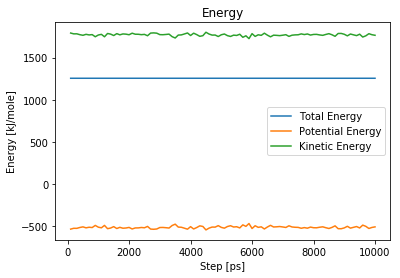

In [18]:
plt.title('Energy')

plt.plot(csv['Step'], csv['Total_Energy_kJmole'], label='Total Energy')
plt.plot(csv['Step'], csv['Potential_Energy_kJmole'], label='Potential Energy')
plt.plot(csv['Step'], csv['Kinetic_Energy_kJmole'], label='Kinetic Energy')


plt.xlabel('Step [ps]')
plt.ylabel('Energy [kJ/mole]')
plt.legend()

# Simulation of an own Integrator

Let's define an own integrator. As we want to improve our simulation results and time is money we decide to use the superior euler algorithm and not waste time with the useless overhead of a verlet integrator. 

## Define a Euler Integrator

We have to define our integrator. Therefore, we create a class `EulerIntegrator` from the baseclass `openmm.CustomIntegrator`.

We only have to reimplement the `__init__` method.
* first `super` the class so we get the methods of `mm.CustomIntegrator`.
* add a step to the integrator to allow changing the simulation step using `addUpdateContextState`
* compute per-DOF values with `addComputePerDof(value, expression)`
* update positions and velocities to satisfy all constraints with `addConstrainPositions()` and `addConstrainVelocities()`

In [20]:
class EulerIntegrator(mm.CustomIntegrator):
    def __init__(self, timestep=1.0 * femtoseconds):
        """Construct a euler integrator.

        Parameters
        ----------
        timestep : np.unit.Quantity compatible with femtoseconds, default: 1*femtoseconds
           The integration timestep.

        """

        super(EulerIntegrator, self).__init__(timestep)
              
        # Add a step to the integration algorithm that allows Forces to update the context state.
        self.addUpdateContextState()
        
        # Add a step to the integration algorithm that computes a per-DOF value.
        self.addComputePerDof("v", "v+dt*f/m")
        self.addComputePerDof("x", "x+dt*v")
        
        # Add a step to the integration algorithm that updates particle positions so
        # all constraints are satisfied.
        self.addConstrainPositions()
        # Add a step to the integration algorithm that updates particle velocities so 
        # the net velocity along all constraints is 0.
        self.addConstrainVelocities()

## Simulation

Let's proceed as normal but use the `EulerIntegrator` as integrator.

In [21]:
# define a system
system = initialize_system(n_particles, mass, box_size)

# create a NonbondedForce (with charge=0 -> only Lennard-Jones interactions)
force = create_NonBonndedForce(n_particles, sigma, epsilon, charge)
force_index = system.addForce(force) 

# create topology
topology = create_topology(n_particles, box_size)

In [22]:
# integrator
integrator = EulerIntegrator(timestep)

In [23]:
# define a simulation context
simulation = app.Simulation(topology=topology, system=system, integrator=integrator)

In [24]:
# set positions
simulation.context.setPositions(positions)
# set velocities
simulation.context.setVelocitiesToTemperature(300 * kelvin)

In [25]:
# minimize
simulation.minimizeEnergy()

In [26]:
# add reporters
simulation.reporters.append(app.DCDReporter('trajectory.bulk.euler.dcd', 100))
simulation.reporters.append(app.StateDataReporter('thermo.bulk.euler.csv', 100,
                                                  step=True,
                                                  potentialEnergy=True,
                                                  kineticEnergy=True,
                                                  totalEnergy=True,
                                                  temperature=True))

In [27]:
simulation.step(10000)

## Visualization

In [28]:
mdtraj_topology = mdtraj.Topology.from_openmm(simulation.topology)
traj = mdtraj.load_dcd('trajectory.bulk.euler.dcd', mdtraj_topology)
view = viz_traj(traj)
view

NGLWidget(count=100)

## Analysis

Let's analyze what we did.

In [29]:
csv = np.genfromtxt('thermo.bulk.euler.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Kinetic_Energy_kJmole', 'Total_Energy_kJmole', 'Temperature_K')


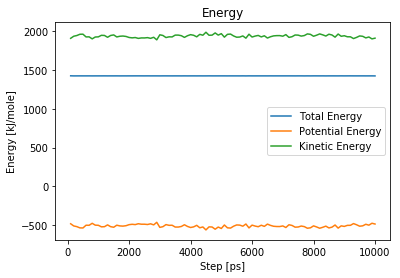

In [30]:
plt.title('Energy')

plt.plot(csv['Step'], csv['Total_Energy_kJmole'], label='Total Energy')
plt.plot(csv['Step'], csv['Potential_Energy_kJmole'], label='Potential Energy')
plt.plot(csv['Step'], csv['Kinetic_Energy_kJmole'], label='Kinetic Energy')


plt.xlabel('Step [ps]')
plt.ylabel('Energy [kJ/mole]')
plt.legend()

As you can see every thing works perfect!

We implemented a new algorithm even faster then the previous one.

# Compare different integrators

Let's compare the different integrators *leap-frog*, *velocity-verlet* and *euler* to prove the supremacy of our integrator.

In [31]:
from copy import deepcopy
import openmmtools

## Init starting values

First repeat the previous protocol and store the positions and velocities after a short equilibration run.

In [32]:
# define a system
system = initialize_system(n_particles, mass, box_size)

# create a NonbondedForce (with charge=0 -> only Lennard-Jones interactions)
force = create_NonBonndedForce(n_particles, sigma, epsilon, charge)
force_index = system.addForce(force) 

# define integrator
integrator = mm.VerletIntegrator(timestep)

# create topology
topology = create_topology(n_particles, box_size)

# define a simulation context
simulation = app.Simulation(topology=topology, system=system, integrator=integrator)

# set positions
simulation.context.setPositions(positions)
# set velocities
simulation.context.setVelocitiesToTemperature(300 * kelvin)

# minimize
simulation.minimizeEnergy()

# equilibrate
simulation.step(10000)

Store the data to use it as starting point.

We use `deepcopy` here to make sure we really get a copy of the data not a pointer to the memory.

In [34]:
state = simulation.context.getState(getPositions=True, getVelocities=True, getEnergy=True)

# get the starting values
start_energies = (state.getPotentialEnergy()+state.getKineticEnergy(), 
                  state.getPotentialEnergy(), 
                  state.getKineticEnergy())
start_positions = deepcopy(state.getPositions())
start_velocities = deepcopy(state.getVelocities())
start_topology = deepcopy(simulation.topology)
start_system = deepcopy(simulation.context.getSystem())

## Define a own reporter

Let's define a own reporter. 

We do not want to write and read a lot of `csv` files but access the data straight in python.

A `reporter` is just an object with an `__init__` method to predefine some variables at the start.
A `describeNextReport(self, simulation)` method to return the next step for a report and a list `boolean` what properties have to be calculated.
Last, a reporter also have a `report(self, simulation, state)` method where we define how to report our data.

We will in this case just tell the `reporter` to calculate the energy by passing `True` to `getEnergy` and reporting is done by appending the energy to the internal list which can later be accessed.

In [35]:
class EnergyReporter(object):
    def __init__(self, reportInterval):
        self._reportInterval = reportInterval
        self._pe = []
        self._ke = []
        self._te = []

    def describeNextReport(self, simulation):
        steps = self._reportInterval - simulation.currentStep%self._reportInterval
        # The number of time steps until the next report.
        # getPositions,
        # getVelocities, 
        # getForces, 
        # getEnergy, 
        # enforcePeriodicBox=False
        return (steps, False, False, False, True, None)
    
    def report(self, simulation, state):
        pe = state.getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        ke = state.getKineticEnergy().value_in_unit(kilojoules_per_mole)
        
        self._pe.append(pe)
        self._ke.append(ke)
        self._te.append(pe+ke)

## test integrators

Let's test all integrators by starting from the same starting positions and velocities.

> Note: use `deepcopy` to make sure you get a copy of the positions because only the pointer is passed to OpenMM!

In [38]:
# define the list of integrators we want to use
integrators = [
    mm.VerletIntegrator(timestep), # leap-frog
    openmmtools.integrators.VelocityVerletIntegrator(timestep), # velocity verlet
    EulerIntegrator(timestep),
    
]
# define the names for them for later use.
list_names = [
    'leap-frog',
    'velocity-verlet',
    'euler'
]
# define a empty list to store our energies in
list_energies = []

# interate over all integrators and start simulations with them.
# add the tuple (totalEnergy, potentialEnergy, kineticEnergy) to list_energies
for integrator in integrators:

    # define a simulation context
    simulation = app.Simulation(topology=deepcopy(start_topology),
                                system=deepcopy(start_system),
                                integrator=integrator)

    # set positions
    simulation.context.setPositions(deepcopy(start_positions))
    # set velocities
    simulation.context.setVelocities(deepcopy(start_velocities))

    simulation.reporters.append(EnergyReporter(100))

    # equilibrate
    simulation.step(10000)
    
    # get energies
    list_energies.append((deepcopy(simulation.reporters[0]._te),
                          deepcopy(simulation.reporters[0]._pe),
                          deepcopy(simulation.reporters[0]._ke)))

## Compare

Let's compare our integrators and check if they can perform a `NVE` simulation.

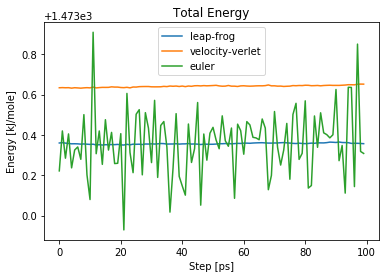

In [39]:
plt.title('Total Energy')

for name, (te, pe, ke) in zip(list_names, list_energies):
    plt.plot(te, label=name)
plt.xlabel('Step [ps]')
plt.ylabel('Energy [kJ/mole]')
plt.legend()

As you can see, our euler algorithm fluctuates quite a bit.

This means it wont fulfil energy conservation on the long run. 

The differences in energies of `leap-frog` and `velocity verlet` are due to half-step vs full-step kinetic energy.


<span style='color:red; font-weight:bold'>It is only the INTEPRETATION of energies and temperature</span>
* <span style='color:red; font-weight:bold'>The drift will still be the same! The trajectories are identical.</span>